In [ ]:
from onnxruntime.transformers.onnx_exporter import torch_func

"""
考虑一个食物网, 有以下生物
生产者:水稻, 稗草
初级消费者:鼠(吃水稻和稗草), 蝗虫(吃水稻和稗草)
次级消费者:蝙蝠(吃蝗虫), 蛇(吃鼠和蝗虫), 蜘蛛(吃蝗虫)
顶级消费者:鹰(吃蛇,蜘蛛和鼠)
细菌(分解者, 由其他生物死亡率与种群大小加权作为养料, 植物消耗它)

最开始的时候, 一部分森林会因为开垦变成农田(表现出来是树和稗草的数量大大减小, 水稻大大增加), 时间间隔T后
农田会被收割, 再过T, 重新播种(不会再次清除树和稗草), 重复播种收割的过程5次,
用Rosenzweig-MacArthur模型构建食物网, 模拟这个过程, 并把每一个T间隔的过程和整体的过程画图, 用scipy
"""

In [256]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import exp
import torch

In [302]:
def precipitation(m):
    """
    模拟东南亚降水量随月份的变化
    - 5~10月（雨季）降水量高
    - 11~4月（旱季）降水量低
    """
    return 1+0.5 * (1 - np.cos(2 * np.pi * (m - 2) / 12))

class Biome:
    def __init__(self, name, params, initial_values, species_indices):
        """
        Initialize the Biome with its name, parameters, initial species values, and species indices.

        Args:
            name (str): Name of the biome (e.g., 'Farm', 'Forest').
            params (tuple): Parameters for the differential equations.
            initial_values (list): Initial population values for each species.
            species_indices (dict): Mapping of species names to their indices in the state vector.
        """
        self.name = name
        self.params = params
        self.initial_values = initial_values
        self.species_indices = species_indices
        self.another = None  # Reference to the other biome for migration

        # Define migration rates for each species
        # Plants have lower migration rates; animals have higher rates
        self.migration_rates = {
            'R': 0,   # 水稻 (Rice)
            'W': 0.0001,   # 稗草 (Barnyard Grass)
            'M': 0.01,    # 鼠 (Mouse)
            'L': 0.01,    # 蝗虫 (Locust)
            'S': 0.005,   # 蛇 (Snake)
            'Sp': 0.005,  # 蜘蛛 (Spider)
            'E': 0.01,   # 鹰 (Eagle)
            'B': 0.001,   # 细菌 (Bacteria)
            'T': 0.001,   # 树 (Tree)
            'Ba': 0.003   # 蝙蝠 (Bat)
        }
        # self.migration_rates = {
        #     'R': 0,   # 水稻 (Rice)
        #     'W': 0.000,   # 稗草 (Barnyard Grass)
        #     'M': 0,    # 鼠 (Mouse)
        #     'L': 0,    # 蝗虫 (Locust)
        #     'S': 0,   # 蛇 (Snake)
        #     'Sp': 0,  # 蜘蛛 (Spider)
        #     'E': 0,   # 鹰 (Eagle)
        #     'B': 0,   # 细菌 (Bacteria)
        #     'T':0,   # 树 (Tree)
        #     'Ba': 0   # 蝙蝠 (Bat)
        # }
        self.current_dir=np.zeros((len(self.species_indices)))
    def set_another(self, other_biome):
        """
        Set the reference to the other biome for migration purposes.

        Args:
            other_biome (Biome): The other biome instance.
        """
        self.another = other_biome

    def fret_func(self, x, t):
        """
        Fertilizer effect function.

        Args:
            x (float): Current fertilizer parameter.
            t (float): Current time.

        Returns:
            float: Modified fertilizer parameter based on time and current value.
        """
        if x <= 0.5:
            return (1 + 1.6 * x**2) * np.exp(-t / 200)
        else:
            return 1.4 * np.exp(-10 * (x - 0.5)) * np.exp(-t / 200)

    def migration_terms(self, y, dy):
        """
        Calculate migration in and out of the biome for each species.

        Args:
            y (list): Current population values of species.

        Returns:
            list: Migration terms for each species.
        """
        sigmoid=lambda x:1/(1+exp(-x))
        migration = np.zeros(len(self.initial_values))
        if self.another:
            for species, rate in self.migration_rates.items():
                idx = self.species_indices[species]
                migration_out = rate * y[idx]
                migration_out*=-sigmoid(dy[idx])+0.5
                migration_in = rate * self.another.initial_values[idx]
                migration_in*=-sigmoid(self.another.current_dir[idx])+0.5
                migration[idx] += migration_in - migration_out
        return migration

    def gen(self, t, y):
        """
        Generate the derivatives for the differential equations, including migration.

        Args:
            t (float): Current time.
            y (list): Current population values of species.

        Returns:
            list: Derivatives of species populations.
        """
        # Unpack parameters
        (
            rR, KR, rW, KW,
            aRM, bRM, eMR, aWM, bWM, eMW,
            aRL, bRL, eLR, aWL, bWL, eLW,
            aSM, bSM, eSM, aSL, bSL, eSL,
            aSpL, bSpL, eSpL,
            aES, bES, eES, aESp, bESp, eESp, aEM, bEM, eEM,
            aBR, bBR, eRB, aBW, bBW, eWB,
            alphaB, dR, dW, dM, dL, dS, dSp, dE, dB,
            rT, KT, aTM, bTM, eTM, aTL, bTL, eTL, dT,
            aBaL, bBaL, eBaL, dBa,
            fret  # Fertilizer parameter
        ) = self.params
        # 考虑降水量因素
        rR*=precipitation(t*(12/100)-1)
        rW*=precipitation(t*(12/100)-1)
        rT*=precipitation(t*(12/100)-1)
        # Species indices
        R = y[self.species_indices['R']]
        W = y[self.species_indices['W']]
        M = y[self.species_indices['M']]
        L = y[self.species_indices['L']]
        S = y[self.species_indices['S']]
        Sp = y[self.species_indices['Sp']]
        E = y[self.species_indices['E']]
        B_ = y[self.species_indices['B']]
        T_ = y[self.species_indices['T']]
        Ba = y[self.species_indices['Ba']]

        # ----- Compute Consumption Rates -----
        # 1) Water Rice (R) Consumption
        cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
        cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
        cons_B_by_R = (aBR * B_ * R) / (1.0 + bBR * B_)
        gain_R_from_B = eRB * cons_B_by_R

        # 2) Barnyard Grass (W) Consumption
        cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
        cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
        cons_B_by_W = (aBW * B_ * W) / (1.0 + bBW * B_)
        gain_W_from_B = eWB * cons_B_by_W

        # 3) Tree (T) Consumption
        cons_T_by_M = (aTM * T_ * M) / (1.0 + bTM * T_)
        cons_T_by_L = (aTL * T_ * L) / (1.0 + bTL * T_)
        gain_M_from_T = eTM * cons_T_by_M
        gain_L_from_T = eTL * cons_T_by_L

        # 4) Mouse (M) Consumption
        gain_M_from_R = eMR * cons_R_by_M
        gain_M_from_W = eMW * cons_W_by_M
        cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
        cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)

        # 5) Locust (L) Consumption
        gain_L_from_R = eLR * cons_R_by_L
        gain_L_from_W = eLW * cons_W_by_L
        cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
        cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)
        cons_L_by_Ba = (aBaL * L * Ba) / (1.0 + bBaL * L)

        # 6) Snake (S) Consumption
        gain_S_from_M = eSM * cons_M_by_S
        gain_S_from_L = eSL * cons_L_by_S
        cons_S_by_E = (aES * S * E) / (1.0 + bES * S)

        # 7) Spider (Sp) Consumption
        gain_Sp_from_L = eSpL * cons_L_by_Sp
        cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)

        # 8) Eagle (E) Consumption
        gain_E_from_S = eES * cons_S_by_E
        gain_E_from_Sp = eESp * cons_Sp_by_E
        gain_E_from_M = eEM * cons_M_by_E

        # 9) Bacteria (B)
        total_death_flux = (
            dR * R + dW * W + dM * M +
            dL * L + dS * S + dSp * Sp +
            dE * E + dT * T_
        )
        bacteria_growth = alphaB * total_death_flux

        # 10) Bat (Ba) Consumption
        gain_Ba_from_L = eBaL * cons_L_by_Ba

        # ----- Compute Derivatives -----
        # Applying fertilizer effect on R, W, T
        modified_rR = rR + 0.01 * Ba * self.fret_func(fret, t)
        modified_rW = rW + 0.01 * Ba * self.fret_func(fret, t)
        modified_rT = rT + 0.01 * Ba * self.fret_func(fret, t)

        dRdt = modified_rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R
        dWdt = modified_rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W
        dTdt = modified_rT * T_ * (1 - T_ / KT) - cons_T_by_M - cons_T_by_L - dT * T_

        dMdt = gain_M_from_R + gain_M_from_W + gain_M_from_T - cons_M_by_S - cons_M_by_E - dM * M
        dLdt = (gain_L_from_R + gain_L_from_W + gain_L_from_T
                - cons_L_by_S - cons_L_by_Sp
                - cons_L_by_Ba - dL * L)
        dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S
        dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp
        dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E
        dBdt = bacteria_growth - dB * B_
        dBadt = gain_Ba_from_L - dBa * Ba

        # ----- Apply Migration Terms -----
        dy=(dR, dW, dM, dL, dS, dSp, dE, dB, dT, dBa)
        migration = self.migration_terms(y, dy)

        # Combine all derivatives
        derivatives = [
            dRdt + migration[self.species_indices['R']],
            dWdt + migration[self.species_indices['W']],
            dMdt + migration[self.species_indices['M']],
            dLdt + migration[self.species_indices['L']],
            dSdt + migration[self.species_indices['S']],
            dSpdt + migration[self.species_indices['Sp']],
            dEdt + migration[self.species_indices['E']],
            dBdt + migration[self.species_indices['B']],
            dTdt + migration[self.species_indices['T']],
            dBadt + migration[self.species_indices['Ba']]
        ]
        self.current_dir=np.array(dy)
        return derivatives

def my_plot(sol_farm, sol_forest, species_labels, ch=True):
    """
    Plot the population dynamics of species in both Farm and Forest biomes.

    Args:
        sol_farm (OdeResult): Simulation results for the Farm biome.
        sol_forest (OdeResult): Simulation results for the Forest biome.
        species_labels (list): List of species names for labeling.
    """
    plt.rcParams['font.family'] = 'Times New Roman'  # For displaying Chinese characters if needed
    plt.figure(figsize=(14, 10))
    plt.xlabel('Time (month) ', fontsize=16)
    plt.ylabel(r"$\text{Biomass}(g /m^2)$", fontsize=16)
    plt.title("Farm simulation results" if ch else "Forest simulation results", fontsize=18)

    for i, label in enumerate(species_labels):
        if ch:
            plt.plot(sol_farm.t, sol_farm.y[i], label=f'{label} - Farm')
        else:
            plt.plot(sol_forest.t, sol_forest.y[i], label=f'{label} - Forest')

    plt.legend()
    plt.grid(True)
    plt.show()

# Define species indices for clarity
species_indices = {
    'R': 0,    # 水稻 (Rice)
    'W': 1,    # 稗草 (Barnyard Grass)
    'M': 2,    # 鼠 (Mouse)
    'L': 3,    # 蝗虫 (Locust)
    'S': 4,    # 蛇 (Snake)
    'Sp': 5,   # 蜘蛛 (Spider)
    'E': 6,    # 鹰 (Eagle)
    'B': 7,    # 细菌 (Bacteria)
    'T': 8,    # 树 (Tree)
    'Ba': 9    # 蝙蝠 (Bat)
}

# Sample parameters (These values are illustrative; adjust as needed)
sample_params = (
    0.5, 100, 0.4, 80,      # rR, KR, rW, KW
    0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aRM, bRM, eMR, aWM, bWM, eMW
    0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aRL, bRL, eLR, aWL, bWL, eLW
    0.01, 0.01, 0.1, 0.01, 0.01, 0.1, # aSM, bSM, eSM, aSL, bSL, eSL
    0.01, 0.01, 0.1,                 # aSpL, bSpL, eSpL
    0.001, 0.01, 0.1, 0.02, 0.01, 0.01, # aES, bES, eES, aESp, bESp, eESp
    0.01, 0.01, 0.18,                 # aEM, bEM, eEM
    0.02, 0.01, 0.1, 0.02, 0.01, 0.1, # aBR, bBR, eRB, aBW, bBW, eWB
    0.2,                             # alphaB
    0.01, 0.01, 0.01, 0.01, 0.01,   # dR, dW, dM, dL, dS
    0.01, 0.01, 0.01,                # dSp, dE, dB
    0.4, 50, 0.01, 0.01, 0.1,        # rT, KT, aTM, bTM, eTM
    0.01, 0.01, 0.1, 0.01,           # aTL, bTL, eTL, dT
    0.01, 0.01, 0.3, 0.01,           # aBaL, bBaL, eBaL, dBa
    0.0                              # fret (Fertilizer parameter)
)

# Initial population values for Farm Biome
sample_initial_vals_farm = [
    50.0,  # R: 水稻 (Rice)
    20.0,  # W: 稗草 (Barnyard Grass)
    15.0,  # M: 鼠 (Mouse)
    10.0,  # L: 蝗虫 (Locust)
    5.0,   # S: 蛇 (Snake)
    3.0,   # Sp: 蜘蛛 (Spider)
    2.0,   # E: 鹰 (Eagle)
    10.0,  # B: 细菌 (Bacteria)
    30.0,  # T: 树 (Tree)
    1.0    # Ba: 蝙蝠 (Bat)
]

# Initial population values for Forest Biome
sample_initial_vals_forest = [
    0.0,  # R: 水稻 (Rice)
    25.0,  # W: 稗草 (Barnyard Grass)
    10.0,  # M: 鼠 (Mouse)
    12.0,  # L: 蝗虫 (Locust)
    4.0,   # S: 蛇 (Snake)
    4.0,   # Sp: 蜘蛛 (Spider)
    3.0,   # E: 鹰 (Eagle)
    8.0,   # B: 细菌 (Bacteria)
    35.0,  # T: 树 (Tree)
    2.0    # Ba: 蝙蝠 (Bat)
]

# Instantiate Biome objects
farm_biome = Biome('农田', sample_params, sample_initial_vals_farm, species_indices)
forest_biome = Biome('森林', sample_params, sample_initial_vals_forest, species_indices)

# Set mutual references for migration
farm_biome.set_another(forest_biome)
forest_biome.set_another(farm_biome)

# Simulation parameters
# t_end = 100      # Total time units
# points = 0.1     # Time interval for evaluation
#
# # Run the simulation for Farm Biome
# sol_farm = solve_ivp(
#     fun=farm_biome.gen,
#     t_span=(0, t_end),
#     y0=farm_biome.initial_values,
#     method='RK45',
#     t_eval=np.arange(0, t_end, points)
# )
#
# # Run the simulation for Forest Biome
# sol_forest = solve_ivp(
#     fun=forest_biome.gen,
#     t_span=(0, t_end),
#     y0=forest_biome.initial_values,
#     method='RK45',
#     t_eval=np.arange(0, t_end, points)
# )
#
# # Species labels for plotting
# species_labels = [
#     '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
#     '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
# ]
# labels = [
#     r'Rice ($\text{S}_1$)', r'Weed ($\text{S}_2$)', r'Mouse ($\text{S}_4$)', r'Locust ($\text{S}_5$)', r'Snake ($\text{S}_6$)',
#     r'Spider ($\text{S}_7$)', r'Eagle ($\text{S}_8$)', r'Bacteria ($\text{B}_{10}$)', r'Tree ($\text{S}_3$)', r'Bat ($\text{S}_9$)']
# # Plot the results
# my_plot(sol_farm, sol_forest, labels, True)
# my_plot(sol_farm, sol_forest, labels, False)
num_epoch=5
save_res={"farm":[], "forest":[]}
tff=np.linspace(0, 50*num_epoch,1000*num_epoch)
for idx_epoch in range(num_epoch):
    num_points=50
    sol_farm=solve_ivp(fun=farm_biome.gen, t_span=(0, num_points), y0=farm_biome.initial_values, method="RK45", t_eval=np.linspace(0, num_points, 1000))
    sol_forest=solve_ivp(fun=forest_biome.gen, t_span=(0, num_points), y0=forest_biome.initial_values, method="RK45", t_eval=np.linspace(0, num_points, 1000))
    # save_res.append({"farm":sol_farm, "forest":sol_forest})
    save_res["farm"].append(sol_farm.y)
    save_res["forest"].append(sol_forest.y)
    P_H=0.1
    farm_biome.initial_values=sol_farm.y[:,-1]
    forest_biome.initial_values=sol_forest.y[:,-1]
    farm_biome.initial_values[species_indices['R']]*=P_H


torch.Size([5, 10, 1000])
torch.Size([5, 10, 1000])
torch.Size([5, 1000, 10])
torch.Size([5, 1000, 10])
(5000, 10)
(5000, 10)


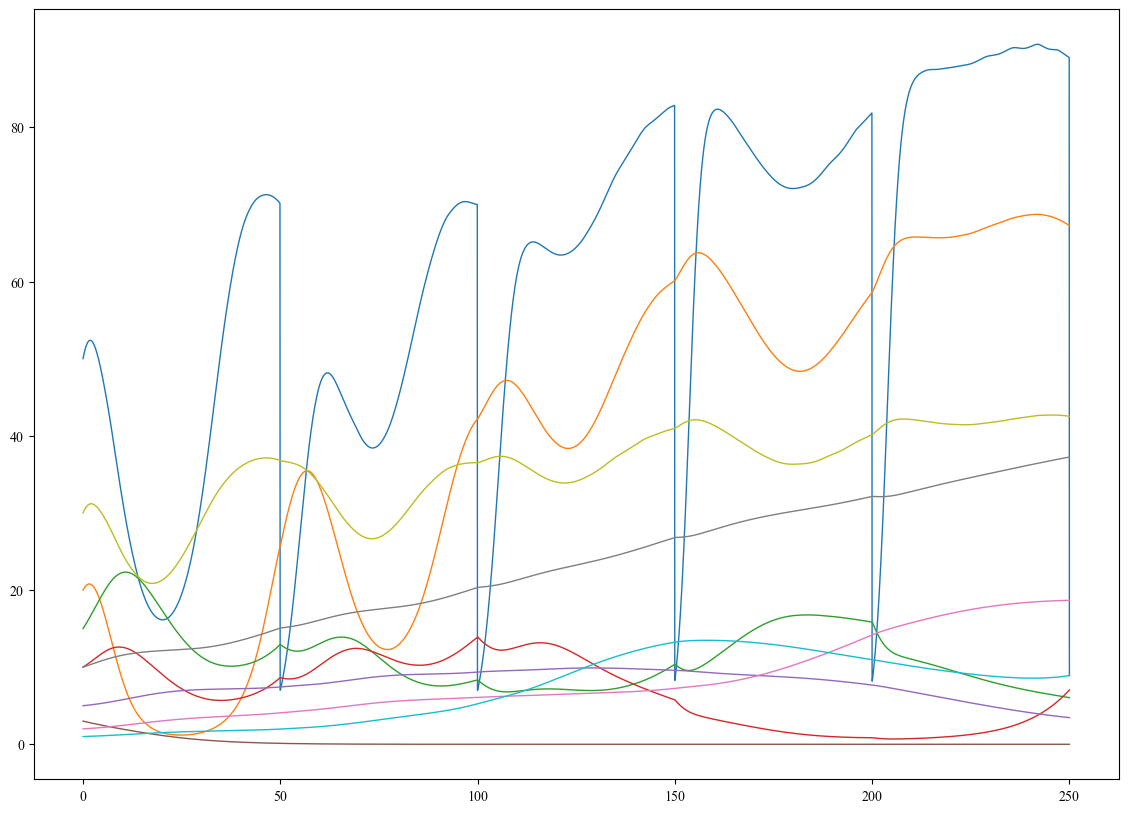

In [305]:
farm_res=torch.from_numpy(np.array(save_res["farm"]))
forest_res=torch.from_numpy(np.array(save_res["forest"]))
print(farm_res.shape)
print(forest_res.shape)
farm_res=torch.permute(farm_res, (0,2,1))
forest_res=torch.permute(forest_res, (0,2,1))
print(farm_res.shape)
print(forest_res.shape)
farm_res=torch.reshape(farm_res, (-1,10)).numpy()
forest_res=torch.reshape(forest_res, (-1,10)).numpy()
print(farm_res.shape)
print(forest_res.shape)
plt.figure(figsize=(14, 10))
for idx in range(farm_res.shape[1]):
    plt.plot(tff, farm_res[:,idx], linewidth=1)
plt.show()
# t0:1 t1:1 t2:3 t:3:1

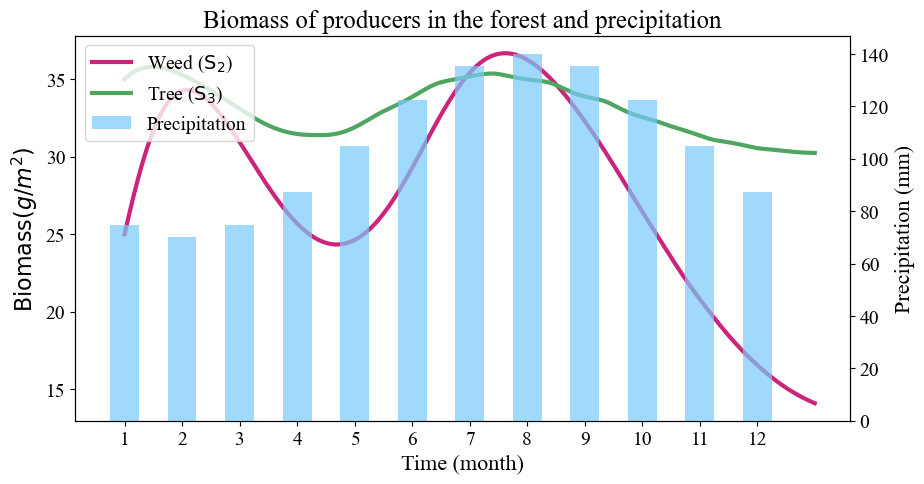

In [158]:
import matplotlib.pyplot as plt

def plot_farm(sol, chi=None, title=""):
    labels = [
        'Rice (R)', r'Weed ($\text{S}_2$)', 'Mouse (M)', 'Locust (L)', 'Snake (S)',
        'Spider (Sp)', 'Eagle (E)', 'Bacteria (B)', r'Tree ($\text{S}_3$)', 'Bat (Ba)']

    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # 左侧 y 轴
    ax1.set_xlabel("Time (month)", fontsize=16)
    ax1.set_ylabel(r"$\text{Biomass}(g /m^2)$", fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)

    r_dix = 0
    color = ["#CC247C", "#4EA660"]
    ttx = [(i * (12 / (sol.t[-1])) + 1) for i in sol.t]

    # 绘制生物量曲线（左轴）
    for idx in range(len(labels)):
        if (chi is not None and idx in chi) or chi is None:
            ax1.plot(ttx, sol.y[idx], label=labels[idx], linewidth=3, color=color[r_dix % 2], zorder=3)
            r_dix += 1

    # 创建右侧 y 轴
    ax2 = ax1.twinx()
    ax2.set_ylabel("Precipitation (mm)", fontsize=16, color='black')
    ax2.tick_params(axis='y', labelsize=14, labelcolor='black')

    # 降雨量数据
    rain = [precipitation(i)*70 for i in range(1,13)]
    rain_t = [i for i in range(1, 13)]

    # 在右轴上绘制柱状图
    ax2.bar(rain_t, rain, width=0.5, alpha=0.7, color='#79CAFB', label="Precipitation", zorder=1)

    # 设置 x 轴刻度
    ax1.set_xticks([i for i in range(1, 13)])

    # 设置标题
    ax1.set_title(title, fontsize=18)

    # 添加图例（需要手动合并两条轴的图例）
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=14, loc="upper left")

    # 保存并显示图像
    plt.savefig("bpf.png", dpi=1000)
    plt.show()

# 调用函数
plot_farm(sol_forest, chi=(1, 8), title="Biomass of producers in the forest and precipitation")


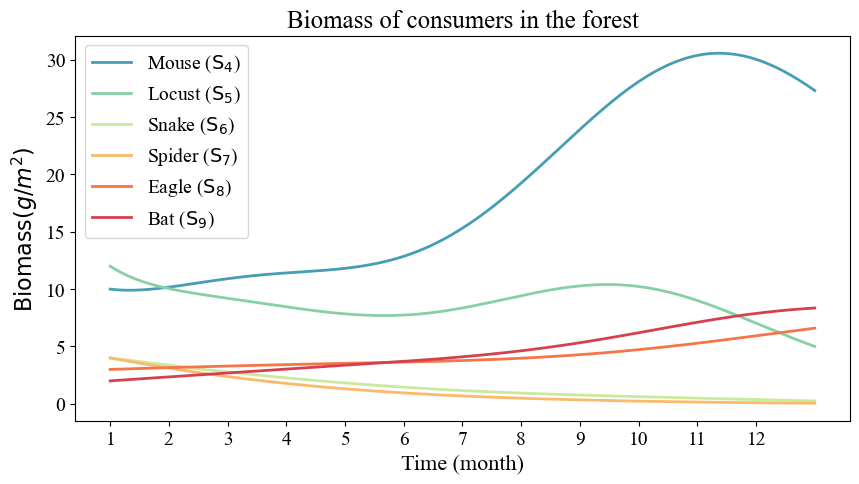

In [86]:
def plot_consumer(sol, chi=None, title=""):
    def rgb_one(*rgb):
        return rgb[0] / 255, rgb[1] / 255, rgb[2] / 255
    labels = [
        r'Rice ($\text{S}_1$)', r'Weed ($\text{S}_2$)', r'Mouse ($\text{S}_4$)', r'Locust ($\text{S}_5$)', r'Snake ($\text{S}_6$)',
        r'Spider ($\text{S}_7$)', r'Eagle ($\text{S}_8$)', 'Bacteria (B)', r'Tree ($\text{S}_3$)', r'Bat ($\text{S}_9$)']
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax1 = plt.subplots(figsize=(10, 5))
    r_dix = 0
    color = [rgb_one(70,158,180), rgb_one(135,207,164), rgb_one(203,233,157), rgb_one(253,185,106), rgb_one(245,117,71), rgb_one(214,64, 78)]
    ttx = [(i * (12 / (sol.t[-1])) + 1) for i in sol.t]
    # 绘制生物量曲线（左轴）
    for idx in range(len(labels)):
        if (chi is not None and idx in chi) or chi is None:
            ax1.plot(ttx, sol.y[idx], label=labels[idx], linewidth=2, color=color[r_dix])
            r_dix += 1
    ax1.set_xticks([i for i in range(1, 13)])
    ax1.set_title(title, fontsize=18)
    ax1.set_xlabel("Time (month)", fontsize=16)
    ax1.set_ylabel(r"$\text{Biomass}(g /m^2)$", fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax1.legend(fontsize=14)
    fig.savefig("bcs.png", dpi=1000)
    plt.show()
plot_consumer(sol_forest, chi=(2,3,4,5,6,9), title="Biomass of consumers in the forest")

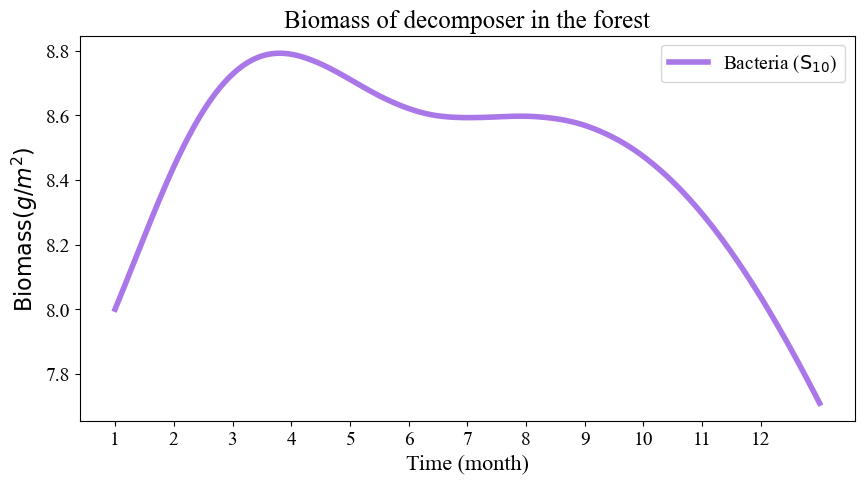

In [98]:
from math import exp
def plot_dec(sol, chi=None, title=""):
    def rgb_one(*rgb):
        return rgb[0] / 255, rgb[1] / 255, rgb[2] / 255
    labels = [
        r'Rice ($\text{S}_1$)', r'Weed ($\text{S}_2$)', r'Mouse ($\text{S}_4$)', r'Locust ($\text{S}_5$)', r'Snake ($\text{S}_6$)',
        r'Spider ($\text{S}_7$)', r'Eagle ($\text{S}_8$)', r'Bacteria ($\text{S}_{10}$)', r'Tree ($\text{S}_3$)', r'Bat ($\text{S}_9$)']
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax1 = plt.subplots(figsize=(10, 5))
    r_dix = 0
    color = ["#AA77E9", rgb_one(135,207,164), rgb_one(203,233,157), rgb_one(253,185,106), rgb_one(245,117,71), rgb_one(214,64, 78)]
    ttx = [(i * (12 / (sol.t[-1])) + 1) for i in sol.t]
    # 绘制生物量曲线（左轴）
    for idx in range(len(labels)):
        if (chi is not None and idx in chi) or chi is None:
            ax1.plot(ttx, [val*exp(-ridx/1500) for ridx, val in enumerate(sol.y[idx])], label=labels[idx], linewidth=4, color=color[r_dix])
            r_dix += 1
    ax1.set_xticks([i for i in range(1, 13)])
    ax1.set_title(title, fontsize=18)
    ax1.set_xlabel("Time (month)", fontsize=16)
    ax1.set_ylabel(r"$\text{Biomass}(g /m^2)$", fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    ax1.legend(fontsize=14)
    fig.savefig("bds.png", dpi=1000)
    plt.show()
plot_dec(sol_forest, chi=(7,), title="Biomass of decomposer in the forest")


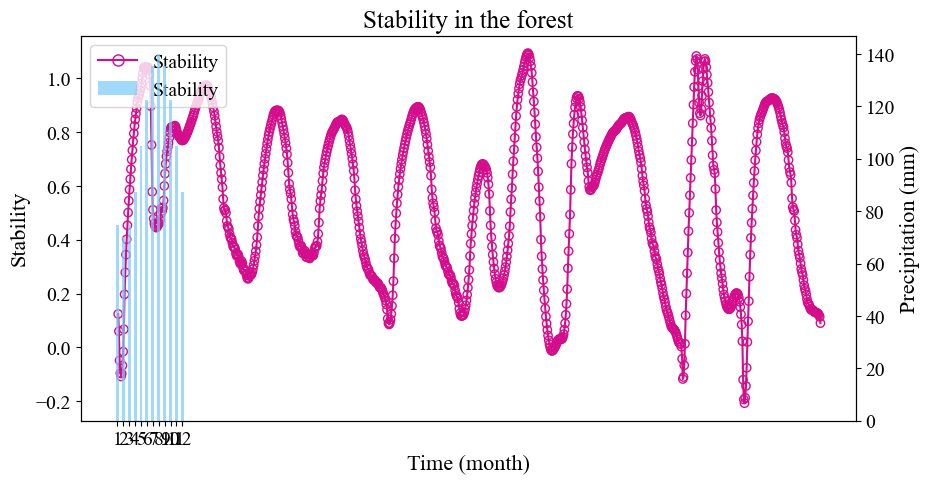

In [207]:
from math import log
def sigmoid(x):
    return 1/(1+exp(-x))
def get_quality(q_sol):
    qu_sat=[]
    for idx in range(q_sol.y.shape[1]):
        tot=sum(q_sol.y[:,idx])
        dirs=forest_biome.gen(t=q_sol.t[idx], y=q_sol.y[:, idx])

        qu_sat.append(sum([-((i/tot)*dirs[cdx+1])*log(abs((i/tot)*dirs[cdx+1])) for cdx,i in enumerate(q_sol.y[1:,idx])])+0.52)
    return qu_sat
qu=get_quality(sol_farm)
def plot_quu(ttq,y, title=""):
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax1=plt.subplots(figsize=(10,5))
    cut=95
    xs=np.array(ttq[cut:])
    ys=np.array(y[cut:])
    xs=xs[0::10]
    ys=ys[0::10]
    ax2=ax1.twinx()
    ax2.set_ylabel("Precipitation (mm)", fontsize=16, color='black')
    ax2.tick_params(axis='y', labelsize=14, labelcolor='black')
    rain = [precipitation(i)*70 for i in range(1,13)]
    rain_t = [i for i in range(1, 13)]
    ax2.bar(rain_t, rain, width=0.5, alpha=0.7, color='#79CAFB', label="Precipitation", zorder=1)
    ax1.plot(xs,ys,linestyle='-', color="#d40d8c")
    ax1.scatter(xs, ys, label="Stability", linewidth=1, color="#d40d8c", marker="o", facecolors='none', linestyle="-")
    ax1.set_xticks([i for i in range(1, 13)])
    ax1.set_title(title, fontsize=18)
    ax1.set_xlabel("Time (month)", fontsize=16)
    ax1.set_ylabel("Stability", fontsize=16)
    ax1.tick_params(axis='both', labelsize=14)
    from matplotlib.lines import Line2D
    legend_element = [Line2D([0], [0], linestyle='-', color='#d40d8c', marker='o', markersize=8, markerfacecolor='none', label="Stability")]
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    combined_legend =  legend_element + lines2
    combined_labels = labels1 + ["Stability"] + labels2

    ax1.legend(combined_legend, combined_labels, fontsize=14, loc="upper left")

    fig.savefig("bqs.png", dpi=1000)
    plt.show()
tt=[(i/10)*(12/100) for i in range(len(qu))]
plot_quu(tt, qu, title="Stability in the forest")

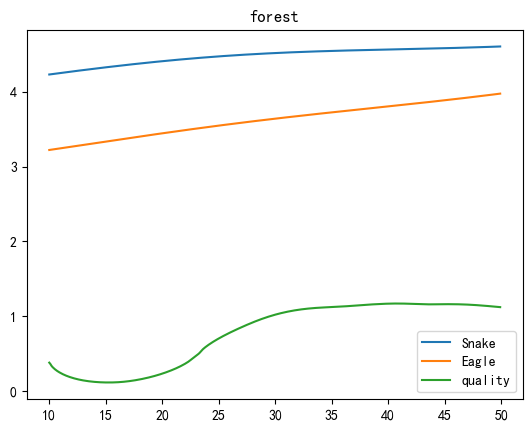

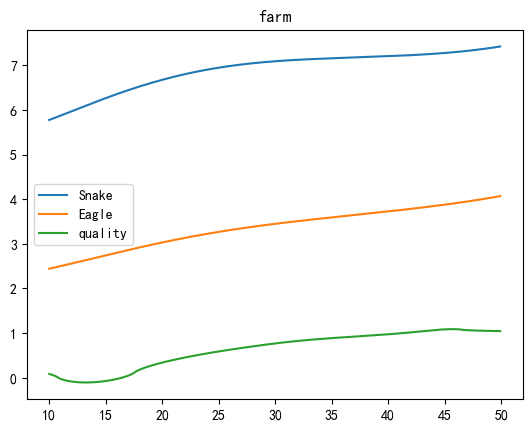

In [226]:
# 蛇和鹰
def plot_snake_eagle(sol, title=""):
    snake=sol.y[species_indices['S']]
    eagle=sol.y[species_indices['E']]
    qu=get_quality(sol)
    cut=100
    plt.plot(sol.t[cut:], snake[cut:], label='Snake')
    plt.plot(sol.t[cut:], np.array(eagle[cut:]), label='Eagle')
    plt.plot(sol.t[cut:], qu[cut:], label="quality")
    plt.title(title)
    plt.legend()
    plt.show()

plot_snake_eagle(sol_forest, "forest")
plot_snake_eagle(sol_farm, "farm")